In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [30]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

In [31]:
df = pd.read_csv('dataset_processed.csv')
df.head(5)

,make,model,year,price,cylinders,fuel,mileage,trim,body,doors,drivetrain,valve_count,fuel_system,valve_train,aspiration,transmission_type,gears,ext_color,int_color
0,Jeep,Wagoneer,2024,74600.0,6.0,Gasoline,10.0,Series II,SUV,4.0,Four-wheel Drive,24.0,GDI,DOHC,twin,automatic,8.0,white,global black
1,Jeep,Grand Cherokee,2024,50170.0,6.0,Gasoline,1.0,Laredo,SUV,4.0,Four-wheel Drive,24.0,unknown,OHV,natural,automatic,8.0,metallic,global black
2,GMC,Yukon XL,2024,96410.0,8.0,Gasoline,0.0,Denali,SUV,4.0,Four-wheel Drive,32.0,GDI,unknown,natural,automatic,8.0,summit white,other
3,Dodge,Durango,2023,46835.0,8.0,Gasoline,26.0,Pursuit,SUV,4.0,All-wheel Drive,16.0,MPFI,OHV,natural,automatic,8.0,white knuckle clearcoat,black
4,RAM,3500,2024,81663.0,6.0,Diesel,10.0,Laramie,Pickup Truck,4.0,Four-wheel Drive,24.0,DDI,OHV,turbo,automatic,6.0,silver,black


## Exploratory Data Analysis (EDA)

In [32]:
print("Dataset shape:", df.shape)

Dataset shape: (979, 19)


In [33]:
print("Data types:\n", df.dtypes)

Data types:
 make                  object
model                 object
year                   int64
price                float64
cylinders            float64
fuel                  object
mileage              float64
trim                  object
body                  object
doors                float64
drivetrain            object
valve_count          float64
fuel_system           object
valve_train           object
aspiration            object
transmission_type     object
gears                float64
ext_color             object
int_color             object
dtype: object


In [34]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 make                 0
model                0
year                 0
price                0
cylinders            0
fuel                 0
mileage              0
trim                 0
body                 0
doors                0
drivetrain           0
valve_count          0
fuel_system          0
valve_train          0
aspiration           0
transmission_type    0
gears                0
ext_color            0
int_color            0
dtype: int64


In [35]:
df['price'].describe()

count       979.000000
mean      50202.985700
std       18700.392062
min           0.000000
25%       36600.000000
50%       47165.000000
75%       58919.500000
max      195895.000000
Name: price, dtype: float64

<small>

The `price` column contains a minimum value of 0, which is not a valid price for any vehicle.  
This likely indicates a data entry error or missing value.   
To address this, we will drop the zero values rows

In [36]:
df = df[df['price'] != 0]

In [37]:
df['price'].describe()

count       978.000000
mean      50254.317996
std       18640.823226
min       17994.000000
25%       36633.500000
50%       47170.000000
75%       58924.750000
max      195895.000000
Name: price, dtype: float64

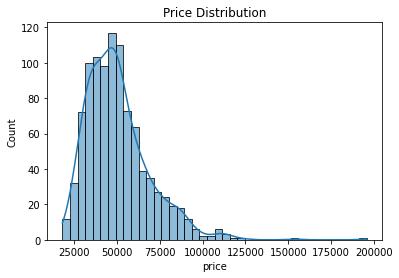

In [38]:
sns.histplot(df['price'], kde=True)
plt.title('Price Distribution')
plt.show()

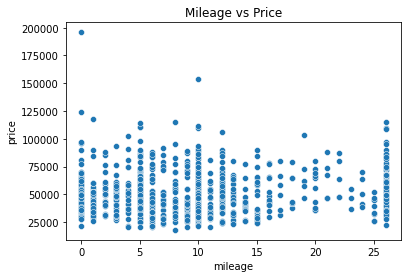

In [39]:
sns.scatterplot(x='mileage', y='price', data=df)
plt.title("Mileage vs Price")
plt.show()

<small>

- The scatterplot shows **no strong linear relationship** between mileage and price.
- **Price is widely spread** across all mileage levels, including at very low and very high mileage.
- There are **no clear threshold effects** (no sudden drop or jump in price at specific mileage values).
- This suggests that **mileage alone is not a strong predictor** of vehicle price, and its effect likely depends on interaction with other features like model, year, and trim.

In [40]:
cat_cols = ['make', 'ext_color', 'int_color', 'year', 'cylinders', 'fuel', 'body', 'doors', 'drivetrain', 
            'valve_count', 'fuel_system', 'valve_train', 'aspiration', 
            'transmission_type', 'gears']

# Not including 'trim', 'model' due to high cardinality

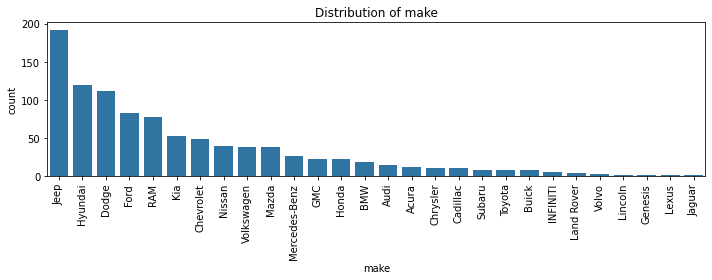

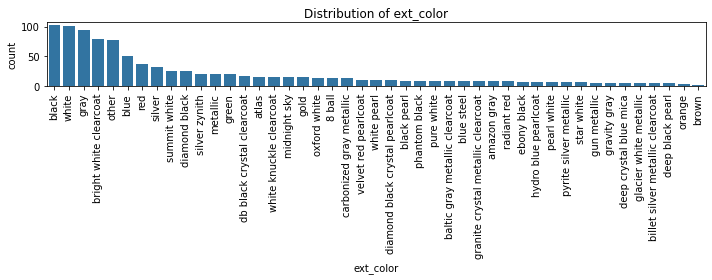

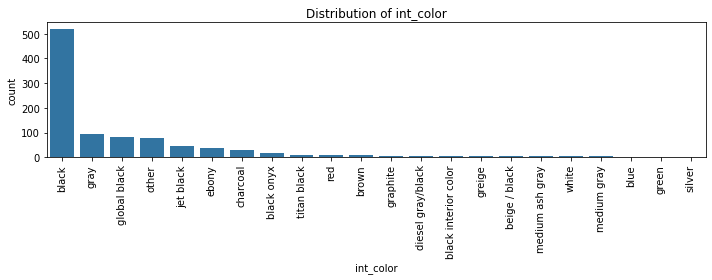

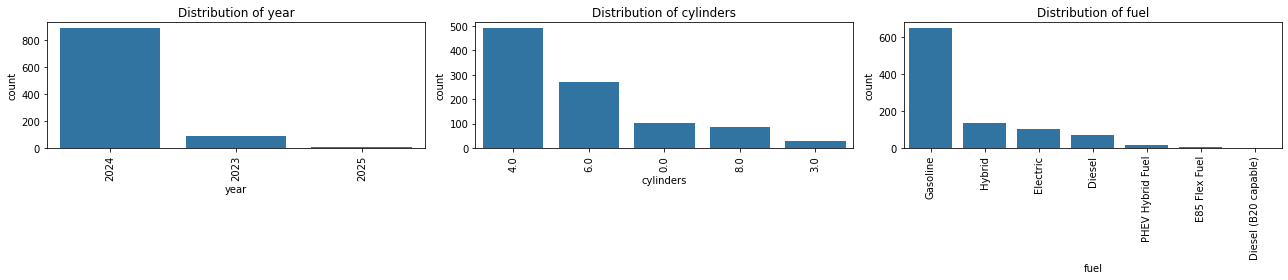

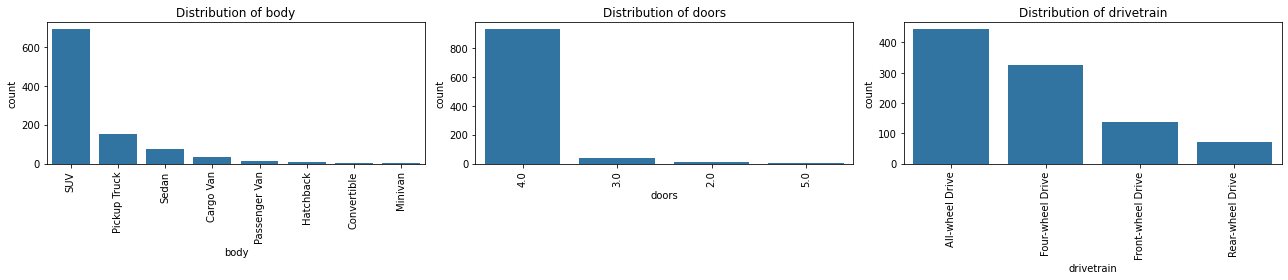

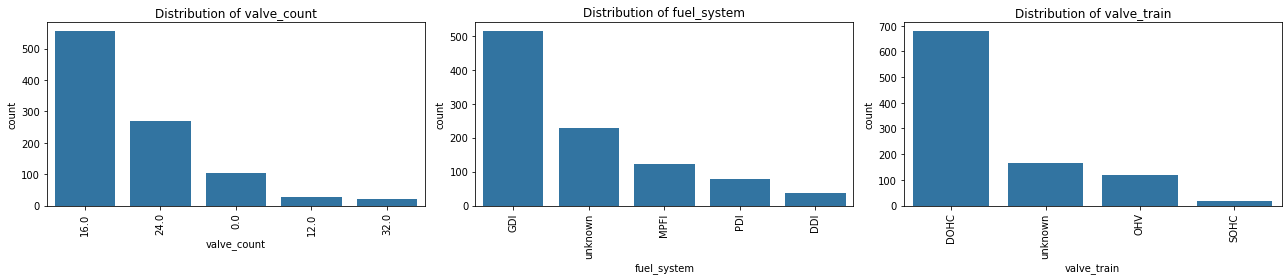

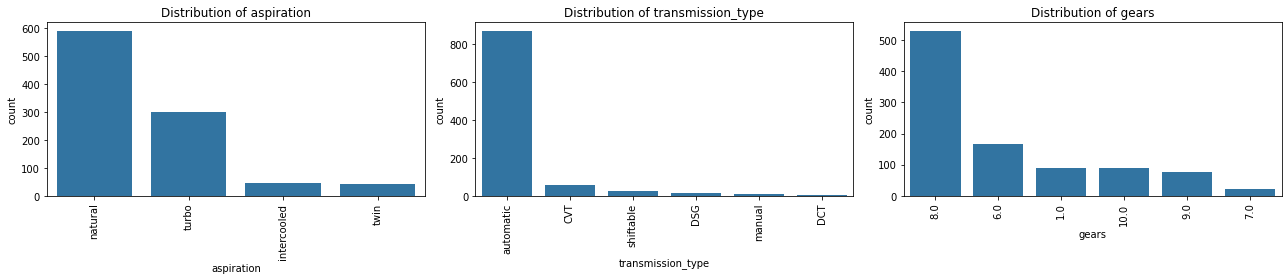

In [41]:
# Plotting count plots for categorical features

for i in range(3):
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, x=cat_cols[i], order=df[cat_cols[i]].value_counts().index)
    plt.title(f"Distribution of {cat_cols[i]}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

for i in range(3, len(cat_cols), 3):
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))  

    for j in range(3):
        if i + j < len(cat_cols):
            col = cat_cols[i + j]
            sns.countplot(data=df, x=col, order=df[col].value_counts().index, ax=axes[j])
            axes[j].set_title(f"Distribution of {col}")
            axes[j].tick_params(axis='x', rotation=90)
        else:
            axes[j].axis('off') 

    plt.tight_layout()
    plt.show()

In [42]:
df.nunique()

make                  28
model                150
year                   3
price                858
cylinders              5
fuel                   7
mileage               27
trim                  87
body                   8
doors                  4
drivetrain             4
valve_count            5
fuel_system            5
valve_train            4
aspiration             4
transmission_type      6
gears                  6
ext_color             45
int_color             22
dtype: int64

## Training Model

In [ ]:
X = df.drop('price', axis=1)
y = df['price']

In [44]:
categorical_cols = ['make', 'model', 'fuel', 'trim', 'body', 'drivetrain',
                    'fuel_system', 'valve_train', 'aspiration', 'transmission_type',
                    'ext_color', 'int_color']

In [45]:
# Preprocessing
preprocessor = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),], remainder='passthrough')

In [ ]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', XGBRegressor(objective='reg:squarederror', n_estimators=200, random_state=42))
])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
pipeline.fit(X_train, y_train)

c:\python\python397\lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['make', 'model', 'fuel',
                                                   'trim', 'body', 'drivetrain',
                                                   'fuel_system', 'valve_train',
                                                   'aspiration',
                                                   'transmission_type',
                                                   'ext_color',
                                                   'int_color'])])),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_by...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [49]:
y_pred = pipeline.predict(X_test)

In [50]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

RMSE: 7123.86
R² Score: 0.8595


In [51]:
scores = cross_val_score(pipeline, X, y, scoring='r2', cv=5)
print("Average R² (5-fold):", scores.mean())

Average R² (5-fold): 0.8110390632856104


## Saving model

In [54]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)